<a href="https://colab.research.google.com/github/AnnaGaluzina/ML-2023/blob/main/ab_testing_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Сравнительная аналитика

В рамках ноутбука поговорим про основные подходы к оценке отличий в выборках

## 1. Освежим t-Распределение Стьюдента

Распределение Стьюдента по сути представляет собой сумму нескольких нормально распределенных случайных величин. Чем больше величин, тем больше верятность, что их сумма будет иметь нормальное распределение. Таким образом, количество суммируемых величин определяет важнейший параметр формы данного распредения - число степеней свободы.

Для начала посмотрим на внешний вид распределения при разных значениях степени свободы

In [2]:
# Для работы с файлами с гугл диска
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


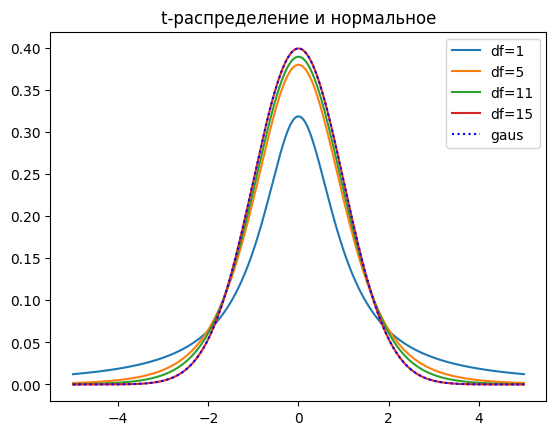

In [3]:
# модули для генерации точек из нормального и t-распределения
from scipy.stats import t, norm
# библиотека для работы с матрицами
import numpy as np
# библиотека для визуализации
import matplotlib.pyplot as plt

x = np.linspace(-5, 5, 1000) # зададим диапазон для случайно величины

# получим значения плотности вероятности для t-распределений
y1, y2, y3, y4 = t.pdf(x, df=1), t.pdf(x, df=5), t.pdf(x, df=10), t.pdf(x, df=15)
# получим значения плотности вероятности для нормального распределения
y4 = norm.pdf(x)

plt.title('t-распределение и нормальное')
plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, y3)
plt.plot(x, y4)
plt.plot(x, y4, 'b:')
plt.legend(('df=1', 'df=5', 'df=11', 'df=15', 'gaus'))
plt.show()

### Подробнее про нормальное и распределение Стьюдента

Вернемся к предельной центральной теореме, мы уже узнали, что если некий признак в генеральной совокупности распределен по **нормальноу закону** со средним $\mu$ и стандартным отклонением $\sigma$, и мы будем многократно извлекать выборки одинакового размера n, и для каждой выборки рассчитывать, как далеко выборочное среднее $\bar{X}$ отклонилось от среднего в генеральной совокупности в единицах стандартной ошибки среднего:

$$Z = \frac{\bar{X} - \mu}{\frac{\sigma}{\sqrt{n}}}$$

тогда эта величина z будет иметь *стандартное* нормальное распределение со $\mu$ равным нулю и $\sigma$ равным единице.

Важно, что для расчета стандартной ошибки используется $\sigma$ ГС (генеральной совокупности). Т.к. ГС почти никогда недоступна, то в расчет берется оценка стандартной ошибки или выборочная стандартная ошибка.

В этом случае, корректнее описывать при помощи t-распределения

$$\large t = \frac{\bar{X} - \mu}{\frac{sd}{\sqrt{n}}}$$

таким образом, в случае неизвестной $\sigma$ мы **всегда будем иметь дело с t-распределением**.

## 2. Идея статистического вывода, p-уровень значимости

Статистический вывод — обобщение информации из выборки для получения представления о свойствах ГС.

В статистическом выводе на основе случайной выборки делаются предположения относительно генеральной совокупности, используя данные о ней. В более общем смысле, данные о некотором случайном процессе, полученные из его наблюдения в течение конечного промежутка времени. Результатом статистического вывода является статистическое суждение, например: точечная оценка, доверительный интервал, отвержение гипотезы.

Проверка статистических гипотез является содержанием одного из обширных классов задач математической статистики. Статистическая гипотеза — предположение о виде распределения и свойствах случайной величины, которое можно подтвердить или опровергнуть применением статистических методов к данным выборки.

Эксперимент – записываются предсказания, генерируются события, проверяется правильность предсказаний.

Основная или нулевая гипотеза $H_0$ - это гипотеза, которой мы придерживаемся, которую мы принимаем до тех пор, пока данные не заставят нас думать, что эта гипотеза невалидна. Ей всегда сопутствует альтернативная гипотеза $H_1$.

Важно отметить следующее: статистические методы не позволяют доказать гипотезу. По наблюдениям, которыми мы располагаем, мы можем гипотезу опровергнуть.

Чтобы определиться, когда гипотезу отвергать, а когда не отвергать, введем еще два понятия.

<img src='img/error_types.jpeg'/>

**Ошибка первого рода** - это ситуация, когда $H_0$ отвергается, хотя она, на самом деле, верна.

**Ошибка второго рода** - это ситуация, когда $H_0$ принимается, хотя она неверна.

Буквой $\alpha$ обозначается уровень значимости или вероятность ошибки первого рода. Буквой $\beta$ - вероятность ошибки второго рода.
Мощностью статистического критерия называется вероятность не совершить ошибку второго рода, то есть $1 − \beta$.

<img src='img/errors_stat_tests.png'/>

Но на основании чего мы будем отвергать гипотезу? **Критическая область** - область значений статистики критерия, при которых отвергается $H_0$. А критические значения - это граница критической области. Т.е., посчитав статистику критерия и проверив с пороговым значением критической области, мы можем сделать вывод об отвержении или не отвержении нулевой гипотезы.

<img src='img/critical_area.png'/>

Таким образом, собрав все знания про то, что такое статистические тесты, давайте опишем как выглядит процедура проверки гипотезы:
1.	Сформулировать основную и альтернативную гипотезы и задать уровень значимости α.
2.	Найти критические значения и построить критическую область.
3.	Вычислить по выборке значение статистики (p-value) и посмотреть, попало ли оно в критическую область.
4.	Сделать вывод. Если значение p-value попало в критическую область, то основная гипотеза отвергается, в противном случае, не отвергается.


### Проверка гипотез
Имеется некоторая выборка размера $n$ из случайной величины $Х$, которая имеет неизвестное распределение $P$:
$$X^n=(X_1, \dots, X_n), X \sim P$$
Имеются следующие гипотезы об этом распределении $P$:
- Нулевая гипотеза $H_0$ – например, $P$ лежит в некотором семействе $\omega$:
    $$H_0: P \in \omega$$
- Альтернативная гипотеза $H_1$ – $P$ не лежит в некотором семействе $\omega$:
    $$H_1: P \notin \omega$$
    
Глядя на собранные данные, нужно проверить, какая из гипотез наиболее вероятна. Для этого используется некоторая статистика $Т$, которая обладает свойством – если справедлива $H_0$, то мы точно знаем, какое у этой статистики распределение:
    $$T(X^n) \sim F(x) \text{, при } H_0$$
    $$T(X^n) \not\sim F(x) \text{, при } H_1$$
Если верна $H_1$, то статистика $Т$ имеет распределение не $F(x)$, а какое-то другое.
- $F(x)$ – нулевое распределение статистики.
- Пара $T$ и $F(x)$ образует статистический критерий для проверки нулевой гипотезы против альтернативной.
- $t$ – значение статистики на полученных данных.

**$p$-value** - достигаемый уровень значимости (вероятность при справедливости $H_0$ можно получить значения статистики $T$ равное $t$ или больше)
    $$p=P(T\geqslant t | H_0).$$
Зная нулевое распределение статистики и значение статистики, которое реализовалось в эксперименте, можно посчитать $p$-value.
Если критическими (т.е. соответствующими альтернативе) являются большие значения статистики, $p$-value равен интегралу от плотности нулевого распределения по «правому хвосту» на диапазоне $[t, +\infty]$. Если полученное $p$-value мало – значит, данные свидетельствуют против $H_0$ в пользу $H_1$.
$p$-value сравнивается с порогом $\alpha$ (**уровень значимости**): $H_0$ отвергается в пользу $H_1$ при $p \leqslant \alpha$. Чаще всего, $\alpha=0.05$ (т.е. $95\%$ доверительный интервал).

***

### Критерий t-Стьюдента

**t-критерий Стьюдента** — общее название для статистических тестов, в которых статистика критерия имеет распределение Стьюдента. Наиболее часто t-критерии применяются для проверки равенства средних значений в двух выборках. Нулевая гипотеза предполагает, что средние равны (отрицание этого предположения называют гипотезой сдвига). Для применения данного критерия необходимо, чтобы исходные данные имели нормальное распределение.

$$ t = \frac{\bar{X_1} - \bar{X_2}}{se}$$

$$ se = \sqrt{\frac{sd_1^2}{n_1} + \frac{sd_2^2}{n_2}} $$

Откуда берётся такая формула $se$?:

$$ (se_1)^2 = (\frac{sd_1}{\sqrt{n_1}})^2 = \frac{sd_1^2}{n_1} $$

То есть:

$$ se = \sqrt{\frac{sd_1^2}{n_1} + \frac{sd_2^2}{n_2}} = \sqrt{se_1^2 + se_2^2} $$

причем ответ на вопрос, почему верно это равенство, кроется в свойстве дисперсии: дисперсия суммы независимых случайных величин равна сумме их дисперсий. а отклонение - это корень из дисперсии.

<img src='img/student_area.jpg'/>

#### Рассмотрим на примере

Пусть у нас имеется информация по росту мужчин одного возраста в двух разных студенческих группах с разных факультетов.

In [4]:
# Импорт необходимых библиотек
import pandas as pd
from scipy.stats import t
import matplotlib.pyplot as plt
import numpy as np

group1 = np.array([173.2, 172.2, 167.7, 170.4, 172.1, 167.9, 174.6, 163.9,
                    174.3, 174.4, 165.5, 174, 164.7, 161.7, 166.6, 161.1,
                    156.1, 168.1, 174.5, 161.3, 158.3, 165.4, 155.3, 175.6,
                    170.1, 168.5, 164.3, 172.2, 159.7, 160.8, 175.9, 160.4,
                    161, 173.8, 162.1, 162.6, 174.9, 169.7, 166.8, 172.8
])

group2 = np.array([160.7, 161.1, 161.4, 178.1, 171.9, 179.5, 171.4, 178.3,
                   176.7, 166.9, 161.8, 181.1, 177.6, 173.9, 173.4, 178.8,
                   172.3, 163.9, 160.5, 171.9, 182, 178.8, 166.2, 161.9,
                   169.3, 175.8, 169, 178.9, 165.5, 164, 160.7, 176.7,
                   178.1, 172.4, 165.3, 172.6, 176, 162.4, 174.9, 165.9
])

# считаем количество элементов, среднее, стандартное отклонение и стандартную ошибку
df = pd.DataFrame({'Группа 1':group1, 'Группа 2':group2}).agg(['count','mean','std','sem']).T
df.columns = ['Размер','Среднее','СКО','SE']

# рассчитываем 95% интервал отклонения среднего
p = 0.95
K = t.ppf((1 + p)/2, df['Среднее']-1)
df['Интервал'] = K * df['SE']

df

,Размер,Среднее,СКО,SE,Интервал
Группа 1,40.0,167.3625,5.95206,0.941103,1.858045
Группа 2,40.0,170.9400,6.82412,1.078988,2.129946


from matplotlib import pyplot as plt
_df_0['Среднее'].plot(kind='hist', bins=20, title='Среднее')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['СКО'].plot(kind='hist', bins=20, title='СКО')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['SE'].plot(kind='hist', bins=20, title='SE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Интервал'].plot(kind='hist', bins=20, title='Интервал')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Среднее', y='СКО', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='СКО', y='SE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='SE', y='Интервал', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Размер']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Размер'}, axis=1)
              .sort_values('Размер', ascending=True))
  xs = counted['Размер']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('Размер', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Размер')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Среднее']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Среднее'}, axis=1)
              .sort_values('Среднее', ascending=True))
  xs = counted['Среднее']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('Среднее', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Среднее')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['СКО']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'СКО'}, axis=1)
              .sort_values('СКО', ascending=True))
  xs = counted['СКО']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('СКО', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('СКО')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['SE']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'SE'}, axis=1)
              .sort_values('SE', ascending=True))
  xs = counted['SE']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('SE', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('SE')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_11['Среднее'].plot(kind='line', figsize=(8, 4), title='Среднее')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['СКО'].plot(kind='line', figsize=(8, 4), title='СКО')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['SE'].plot(kind='line', figsize=(8, 4), title='SE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['Интервал'].plot(kind='line', figsize=(8, 4), title='Интервал')
plt.gca().spines[['top', 'right']].set_visible(False)

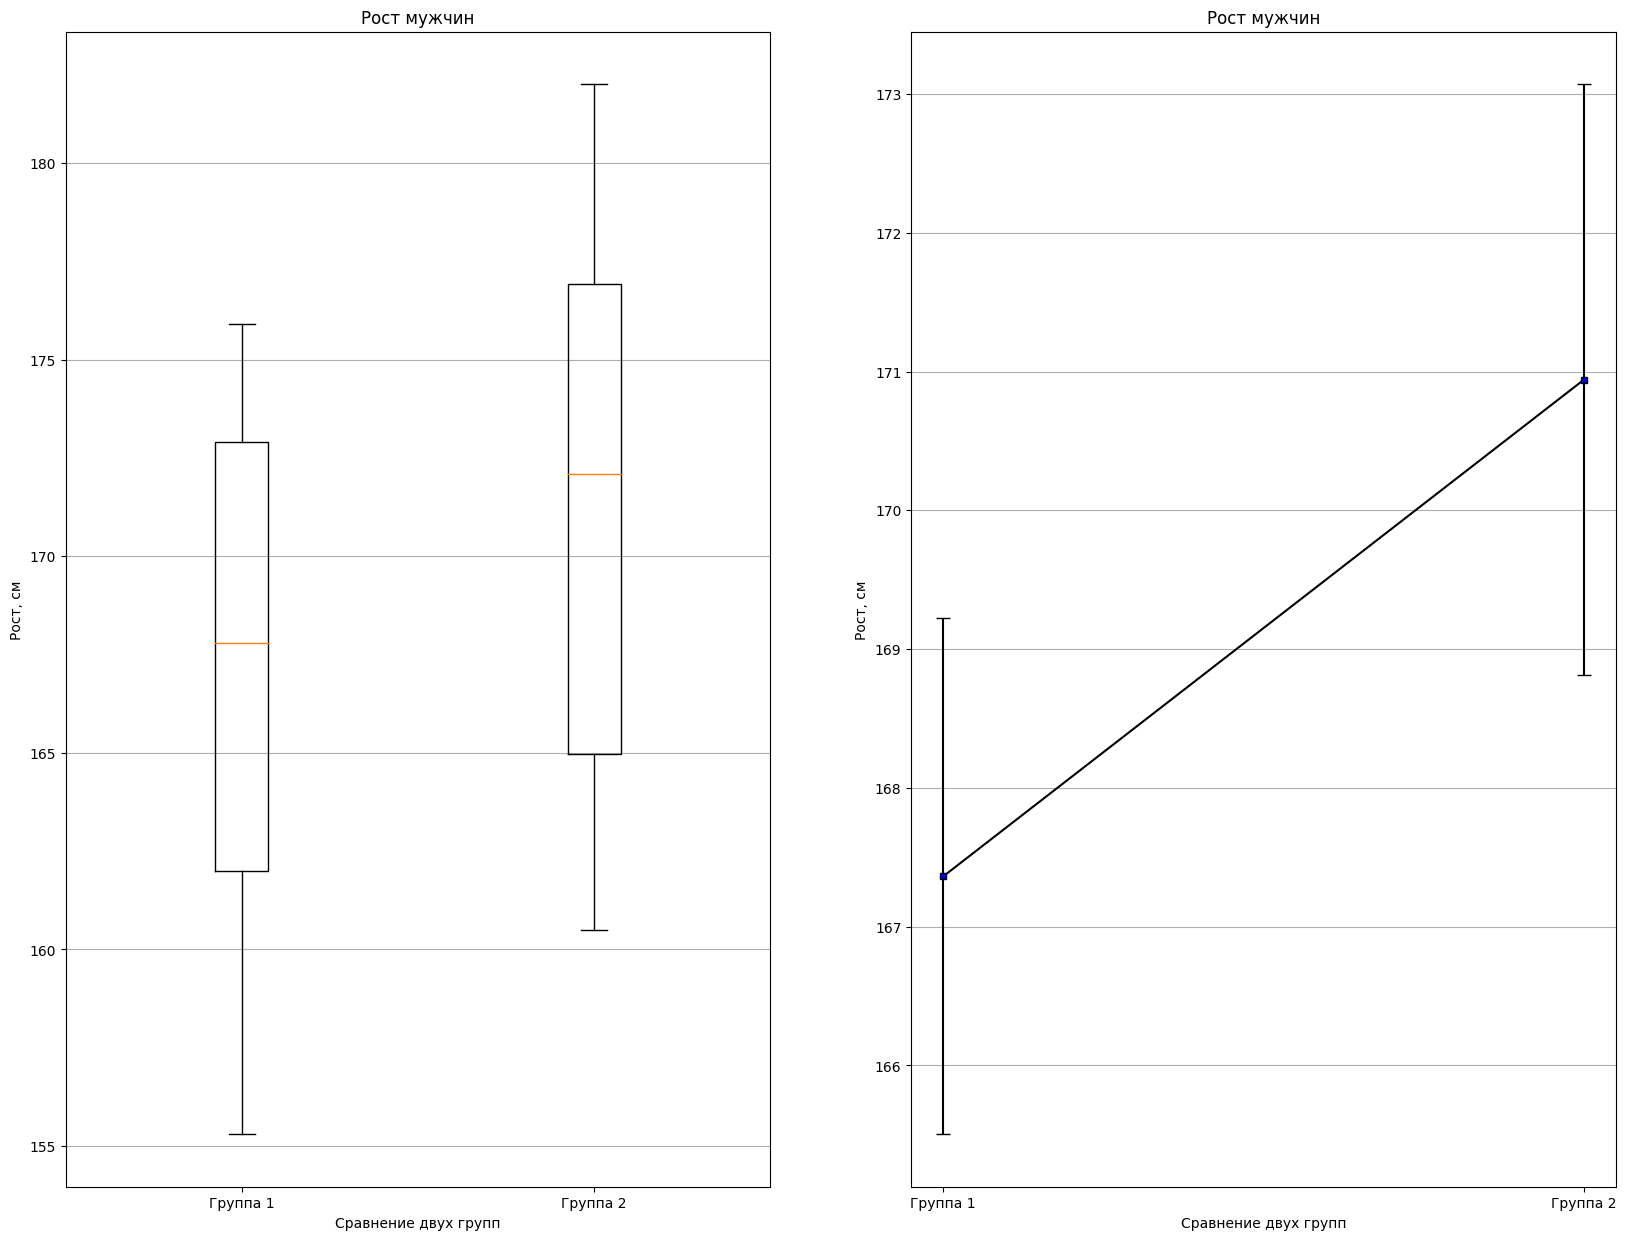

In [5]:
#строим графики, boxplot из изначальных данных array1, array2,  доверительные интервалы из датафрейма df
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 15))

# график boxplot
bplot1 = ax1.boxplot([group1, group2],
                     vert=True,
                     labels=['Группа 1', 'Группа 2'])

# график доверительных интервалов
bplot2 = ax2.errorbar(x=df.index,
                      y=df['Среднее'],
                      yerr=df['Интервал'],
                      color="black",
                      capsize=5,
                      marker="s",
                      markersize=4,
                      mfc="blue",
                      mec="black")

# добавим общие для каждого из графиков данные
for ax in [ax1, ax2]:
    ax.yaxis.grid(True)
    ax.set_title('Рост мужчин')
    ax.set_xlabel('Сравнение двух групп')
    ax.set_ylabel('Рост, см')

plt.show()

## A/B тесты

### Что такое A/B тестирование, зачем и для кого это нужно?

У приведенных выше подходов для расчета различных статистик по группам есть очень важное бизнесовое применение. Это A/B-тестирование, позовляющее на основании выделения целевой и контрольной групп, выявлять статистически значимые отличия в поведении этих групп и на основании этих отличий принимать решения об изменении в бизнесе. A/B-тестирование — это неотъемлемая часть процесса работы над продуктом. Это эксперимент, который позволяет сравнить две версии чего-либо, чтобы проверить гипотезы и определить, какая версия лучше. Какая цена лучше, какой дизайн более привлекательный, какая навигация лучше, какой офер более интересен абоненту? Но это не всегда история про успешные тестирования и постоянный рост. В первую очередь надо думать, как не сделать проект хуже.

Кому нужно A/B-тестирование? - всем, кто хочет улучшать свой продукт, делать его удобнее и приятнее для целевой аудитории. Например,
- Продакт-менеджеры могут тестировать изменения ценовых моделей, направленные на повышение доходов, или оптимизацию части воронки продаж для увеличения конверсии.
- Маркетологи могут тестировать изображения, призывы к действию (call-to-action) или практически любые другие элементы маркетинговой кампании или рекламы с точки зрения улучшения метрик.
- Продуктовые дизайнеры могут тестировать дизайнерские решения или использовать результаты тестирования для того, чтобы перед внедрением определить, будет ли удобно пользоваться новой функцией.

### Основные шаги A/B тестирования:
1. определить цель
2. выбрать метрику:
    - конверсия,
    - экономические метрики,
    - поведенческие факторы,
    - ...
3. выдвинуть гипотезу
4. настроить эксперимент
5. запустить эксперимент
6. проанализировать результаты

### Как проводить A/B тесты?

Нужно определить две гипотезы, которые помогут понять, является ли наблюдаемая разница между версией A (изначальной) и версией B (новой, которую вы хотите проверить) случайностью или результатом изменений, которые вы произвели.

**Нулевая гипотеза** предполагает, что результаты, `А` и `В` на самом деле не отличаются и что наблюдаемые различия случайны. Мы надеемся опровергнуть эту гипотезу.
**Альтернативная гипотеза** — это гипотеза о том, что `B` отличается от `A`, и вы хотите сделать вывод об её истинности.
Можно проводить односторонний или двусторонний тест. Односторонний тест позволяет обнаружить изменение в одном направлении, в то время как двусторонний тест позволяет обнаружить изменение по двум направлениям (как положительное, так и отрицательное).  

Для того, чтобы тест выдавал корректные результаты:
- Создайте новую версию (B), отражающую изменения, которые вы хотите протестировать.
- Определите контрольную и экспериментальную группы. Каких пользователей вы хотите протестировать: всех пользователей на всех платформах или только пользователей из одной страны? Определите группу испытуемых, отобрав их по типам пользователей, платформе, географическим показателям и т. п. Затем определите, какой процент исследуемой группы составляет контрольная группа (группа, видящая версию A), а какой процент — экспериментальная группа (группа, видящая версию B).
- Убедитесь, что пользователи будут видеть версии A и B в случайном порядке. Это значит, у каждого пользователя будет равный шанс получить ту или иную версию.
- Определите уровень статистической значимости ($\alpha$). Это уровень риска, который вы принимаете при ошибках первого рода (отклонение нулевой гипотезы, если она верна), обычно $\alpha = 0.05$. Это означает, что в $5\%$ случаев вы будете обнаруживать разницу между A и B, которая на самом деле обусловлена случайностью. Чем ниже выбранный вами уровень значимости, тем ниже риск того, что вы обнаружите разницу, вызванную случайностью.
- Определите минимальный размер выборки. Наличие достаточно большого размера выборки важно для обеспечения статистически значимых результатов.
- Определите временные рамки. Возьмите общий размер выборки, необходимый вам для тестирования каждой версии, и разделите его на ваш ежедневный трафик, так вы получите количество дней, необходимое для проведения теста.

Сколько должен длиться эксперимент? Сколько пользователей должно быть в тестовой выборке?

Для начала нужно определить следующее:
- минимальный размер эффекта, который мы хотим померить (насколько большие отклонения от метрики, которая, мы предполагаем, сохраниться по умолчанию, мы хотим "замечать")
- допустимые вероятности ошибок первого и второго рода (ошибка первого рода — ситуация, когда отвергнута верная нулевая гипотеза и ошибка второго рода — ситуация, когда принята неверная нулевая гипотеза); стоимости этих ошибок могут существенно отличаться, и в зависимости от этого нужно выбирать пороги.
    
С помощью калькулятора мощности выбранного статистического критерия можно будет расчитать размеры выборки (калькуляторы [здесь](https://www.optimizely.com/sample-size-calculator/?conversion=3&effect=20&significance=95) и [здесь](https://www.abtasty.com/sample-size-calculator/)).

[Калькулятор достоверности A/B тестирования](https://yandex.ru/adv/statvalue).

Рассмотрим аналитику A/B теста на примере.
***

# Пример оценки A/B теста

Рассмотрим процесс анализа A/B-теста: от формулирования гипотезы и ее проверки до интерпретации результатов. Будем использовать <a href='https://www.kaggle.com/zhangluyuan/ab-testing?select=ab_data.csv'> набор данных от Kaggle </a>, который содержит результаты A/B-тестирования двух разных дизайнов страницы веб-сайта (old_page и new_page).

1. [Разработка эксперимента](#1.-Разработка-эксперимента)
2. [Предобработка данных](#2.-Предобработка-данных)
3. [Визуализация результатов](#3.-Визуализация-результатов)
4. [Проверка гипотезы](#4.-Проверка-гипотезы)
5. [Выводы](#5.-Выводы)

Вот потенциальный **сценарий** для нашего исследования:

> Представим, что вы работаете в группе разработчиков **e-commerce компании**. Дизайнер UX поработал над новой версией страницы продукта, надеясь, что это приведет к более высокому коэффициенту конверсии. Менеджер по продукту сказал вам, что **текущий коэффициент конверсии** составляет в среднем **13%** в течение года, и что команда будет довольна **увеличением на 2%**, что означает что новый дизайн будет считаться успешным, если он поднимет коэффициент конверсии до 15%.

Перед развертыванием изменения команде было бы удобнее протестировать его на небольшом количестве пользователей, чтобы увидеть, как оно работает, поэтому вы предлагаете выполнить **A/B-тест** на подмножестве пользователей вашей пользовательской базы.

***
## 1. Разработка эксперимента

### Формулирование гипотезы

Прежде всего, мы хотим убедиться, что сформулировали гипотезу в начале нашего проекта. Это обеспечит правильность и строгость нашей интерпретации результатов.

Поскольку мы не знаем, будет ли новый дизайн работать лучше или хуже (или будет таким же?), чем наш текущий дизайн, мы выберем <a href="https://en.wikipedia.org/wiki/One-_and_two-tailed_tests">**двусторонний тест** </a>:

$$ H_0: p = p_0 $$
$$ H_a: p \ne p_0 $$

где $p$ и $p_0$ обозначают коэффициент конверсии нового и старого дизайна соответственно. Мы также установим **уровень доверия $95\%$**:

$$ \alpha = 0,05 $$

Значение $ \alpha $ - это установленный нами порог: «Если вероятность получения результата как экстремального или большего ($p $ -значение) ниже, чем $ \alpha $, то мы отклоняем нулевую гипотезу». Поскольку $ \alpha = 0,05 $ (что указывает на вероятность $5\%$), наша уверенность ($1-\alpha $) составляет $95\%$.

Какой бы коэффициент конверсии мы ни наблюдали для нашего нового дизайна в нашем тесте, мы хотим быть уверены на $95\%$, что он статистически отличается от коэффициента конверсии нашего старого дизайна, прежде чем мы решим отвергнуть нулевую гипотезу $ H_0 $.

### Выбор переменных

Для нашего теста нам понадобятся **две группы**:
* `Контрольная` группа  - им будет показан старый дизайн
* `Целевая` группа - им будет показан новый дизайн.

Это будет наша *независимая переменная*. Причина, по которой у нас есть две группы, хотя мы знаем базовый коэффициент конверсии, заключается в том, что мы хотим контролировать другие переменные, которые могут повлиять на наши результаты, такие как сезонность: имея `контрольную` группу, мы можем напрямую сравнивать их результаты с `целевой` группой, потому что единственное систематическое различие между группами - это дизайн страницы продукта, и поэтому мы можем связать любые различия в результатах с дизайном.

В качестве *зависимой переменной* (т.е. того, что мы пытаемся измерить), мы будем отслеживать `коэффициент конверсии`. Мы можем закодировать это бинарной переменной с помощью каждой пользовательской сессии:
* `0` - пользователь не покупал товар во время этой пользовательской сессии.
* `1` - пользователь купил продукт во время этой пользовательской сессии.

Таким образом, мы можем легко вычислить среднее значение для каждой группы, чтобы получить коэффициент конверсии каждого дизайна.

### Выбор размера выборки

Важно отметить, что, т.к. мы не будем тестировать всю базу пользователей, полученные нами коэффициенты конверсии неизбежно будут лишь *оценками* истинных коэффициентов.

Количество людей (или пользовательских сеансов), которых мы решаем охватить в каждой группе, повлияет на точность наших расчетных коэффициентов конверсии: **чем больше размер выборки**, тем точнее наши оценки (т.е. тем меньше доверительные интервалы), **тем выше шанс обнаружить разницу** в двух группах, если они есть.

С другой стороны, чем больше становится наша выборка, тем дороже становится наше исследование.

*Сколько человек должно быть в каждой группе?*

Размер необходимой нам выборки оценивается с помощью *анализа мощности*, и это зависит от нескольких факторов:
* **Мощность теста** ($ 1 - \beta $) - представляет собой вероятность обнаружения статистической разницы между группами в нашем тесте, когда разница действительно присутствует. Обычно это значение устанавливается на $0,8$.
* **Альфа-значение** ($ \alpha $) - критическое значение, которое мы ранее установили равным $0,05$.
* **Размер эффекта** - насколько большой, по нашему мнению, будет разница между коэффициентами конверсии.

Поскольку наша команда была бы довольна разницей в $2\%$, мы можем использовать $13\%$ и $15\%$ для расчета ожидаемого эффекта.

In [25]:
# Импорт необходимых библиотек
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

%matplotlib inline

In [26]:
# Посчитаем ожидаем прирост эффекта на основании выбранных изменений в конверсии от 13% к 15%
effect_size = sms.proportion_effectsize(0.13, 0.15)

# Расчет необходимого размера выборки
required_n = sms.NormalIndPower().solve_power(
    effect_size,
    power=0.8,
    alpha=0.05,
    ratio=1
)

Установка параметра `мощности` на $0.8$ на практике означает, что если существует реальная разница в коэффициенте конверсии между нашими проектами, предполагая, что разница является той, которую мы оценили ($13\%$ против $15\%$), у нас есть $80\%$ шанс определить его как статистически значимый в нашем тесте с размером выборки, который мы рассчитали.

***
## 2. Предобработка данных

Теперь, когда у нас есть требуемый размер выборки, нам нужно собрать данные. Обычно на этом этапе нужно настроить эксперимент и убедиться, что собрано достаточно данных на основе необходимого размера выборки.

Поскольку мы используем набор данных, который мы нашли в Интернете, для моделирования этой ситуации:
1. Загрузим <a href='https://www.kaggle.com/zhangluyuan/ab-testing?select=ab_data.csv'> набор данных из Kaggle </a>.
2. Считаем данные в pandas DataFrame.
3. Проверим и очистим данные.
4. Выберем из датасета количество точек, которое мы получили на предыдущем шаге.

***Примечание**: Обычно нам не нужно выполнять шаг 4, это только ради упражнения.

In [27]:
# чтение данных из csv файла
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ab_data.csv')

# выведем первые 10 строк
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [28]:
# выведем информацию по датафрейму
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


У нас **294478 строк**, каждая из которых представляет сеанс пользователя, а также **5 столбцов**:
* `user_id` - ID пользователя каждой сессии
* `timestamp` - времея сеанса
* `group` - группа пользователя для этого сеанса {`control`, `treatment`}
* `landing_page` - какой дизайн каждый пользователь видел в этом сеансе {` old_page`, `new_page`}
* `convert` - завершился ли сеанс конверсией или нет (двоичный,` 0` = без конверсии, `1` = с конверсией)

Будем использовать для анализа столбцы «group» и «convert».

Необходимо проверить, что нет пользователей, которые были выбраны несколько раз и что не было пользователей, которые видели не свою версию сайта (т.е. `целевая` только `new`, `контрольная` только `old`)

Видим, что пропусков в данных нет и можно далее анализировать таблицу

> # Задание
>
> При помощи pd.crosstab проверить, нет ли подглядываний в таблице. Т.е. не видели ли пользователи из целевой группы старую версию и из контрольной новую.

In [30]:
# Проверим, не было ли "подглядываний"
pd.crosstab(df.group, df.landing_page)

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


> # Задание
>
> Если подглядывания есть, то необходимо удалить такие записи

In [31]:
# Удалить "подглядывания"
df = df[(df.group == 'control') & (df.landing_page == 'old_page') | (df.group == 'treatment') & (df.landing_page == 'new_page')]

In [32]:
# При помощи pd.crosstab убедиться, что подглядываний нет
pd.crosstab(df.group, df.landing_page)

landing_page,new_page,old_page
group,,
control,0,145274
treatment,145311,0


> # Задание
>
> Проверить, есть ли пользователи, которые встречаются несколько раз в выборке

In [33]:
# Проверить, есть ли пользователи, которые встречаются более 1 раза
df[df.duplicated('user_id')]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [34]:
len(df['user_id'].unique()) == len(df)

False

> # Задание
>
> Если есть пользователи, которые появляются более одного раза. то необходимо удалить их из данных, чтобы избежать дублирования в выборке.

In [15]:
# Если есть, то удалить пользователей, которые встречаются более 1 раза
df = df[~df.duplicated('user_id')]

### Выборка

Теперь, когда данные чистые, мы можем выбрать `required_n` записей для каждой из групп. Для этого мы можем использовать метод pandas `DataFrame.sample()`, который выберет случайную выборку. Зафиксируем при этом `random_state`, чтобы получать одни и те же результаты.

In [35]:
required_n

4719.4740575998185

In [36]:
# Сформируем контрольную группу
control_sample = df[df['group'] == 'control'].sample(n=int(required_n), random_state=22)

# Сформируйте целевую группу такого же размера и с тем же random_state
treatment_sample =  df[df['group'] == 'treatment'].sample(n=int(required_n), random_state=22)

# Объединим полученные наборы данных
ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

> # Задание
>
> Проверьте, что в ab_test все в порядке. Нет пустых записей, дублей, подглядываний, размеры соответствуют `required_n`

In [41]:
# Все ли ок с ab_test?
# Нет пустых записей
ab_test.isna().sum().mean() == 0

True

In [42]:
# Нет дублей
len(ab_test["user_id"].unique()) == len(ab_test)

True

In [43]:
# Матрица подглядываний
pd.crosstab(ab_test['group'], ab_test['landing_page'])

landing_page,new_page,old_page
group,,
control,0,4719
treatment,4719,0


In [44]:
# Размеры соответветствуют required_n
int(required_n)*2 == len(ab_test)

True

***
## 3. Визуализация результатов

> # Задание
>
> Вычислите **основные статистики**, чтобы получить представление о том, как выглядят наши данные. Среднее, стандартное отклонение и стандартную ошибку ($\frac{std}{\sqrt(n)}$)

In [19]:
conversion_rates = ab_test.groupby('group')['converted']

print_param_conv_rates = conversion_rates.agg(['count','mean','std','sem'])
print_param_conv_rates.columns = ['Размер','Среднее','СКО','SE']

print_param_conv_rates

,Размер,Среднее,СКО,SE
group,,,,
control,4719,0.120364,0.325422,0.004737
treatment,4719,0.117822,0.322431,0.004694


> # Вопрос
>
> Похожи ли поведения клиентов?

<ipython-input-20-21982b4d6101>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)


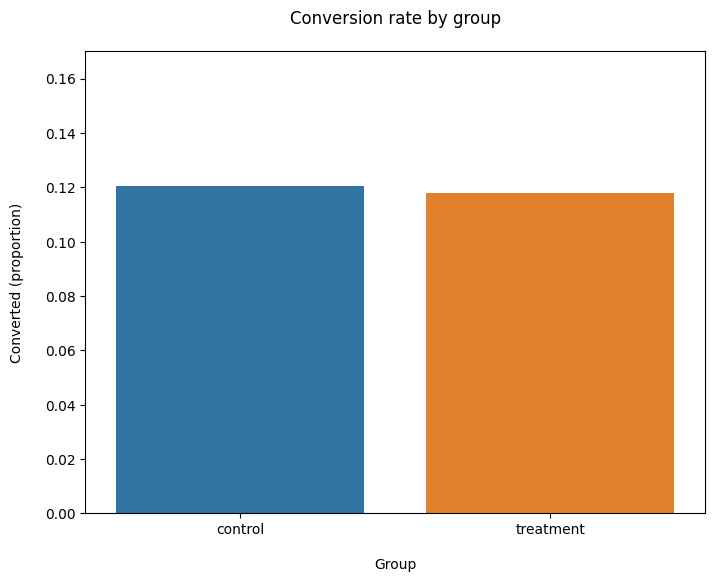

In [20]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

А теперь давайте ответим на вопрос **Является ли разница статистически значимой?**

***
## 4. Проверка гипотезы

Поскольку у нас большая выборка, мы можем использовать нормальное приближение для вычисления нашего $p$-значения (т.е. z-тест).

Мы можем использовать модуль `statsmodels.stats.proportion`, чтобы получить $p$-значение и доверительные интервалы:

In [21]:
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

Пусть $X$ - переменная, описывающая контрольную группу, а $Y$ - переменная, описывающая целевую группу. Имеем: $X \sim Bin(n,p_1)$ и $Y \sim Bin(m,p_2)$. Гипотезы:

\\[ \begin{array}{ll} H_0 :& p_1 = p_2 \\
H_1 :& p_1 \neq p_2\\ \end{array} \\]


Целью нашего теста является сравнение двух конверсий. Так как наши переменные биномиальные, статистика имеет следующий вид:
\\[ Z = \frac{ \hat{Y} - \hat{X} }{\sqrt{P(1-P)( \frac{1}{n} + \frac{1}{m})}} \\]
\\[ \begin{array}{ll} \hat{X} & \mbox{эмпирическое среднее контрольной группы}\\
\hat{Y} & \mbox{эмпирическое среднее целевой группы}\\
n & \mbox{размер контрольной группы} \\
m & \mbox{размер целевой группы} \\
P = \frac{n\hat{X} + m\hat{Y}}{n+m} & \mbox{}
\end{array} \\]
При верной $H_0$ имеем: $Z \sim \mathit{N}(0,1)$.

Рассчитаем значения z статистики и $p$-значение с помощью библиотеки `statsmodels`:

In [46]:
successes = [control_results.sum(), treatment_results.sum()]
n_con, n_treat= len(control_results), len(treatment_results)
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'confidence interval 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'confidence interval 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 0.38
p-value: 0.703
confidence interval 95% for control group: [0.111, 0.130]
confidence interval 95% for treatment group: [0.109, 0.127]


**Вывод:**
Значение достигаемого уровня значимости p-value составило 0.703. По условию задачи уровень доверия составляет 0.95, cледовательно, α=0.05.
Видим, что p-value > α, таким образом, нулевая гипотеза не отвергается.